#### Rebecca Black

## Pump it Up: Data Mining the Water Table
#### Driven Data Competition

This is an analysis of data obtained from Taarifa and the Tanzanian Ministry of Water via the Driven Data website (https://www.drivendata.org). The objective is to predict with as much accuracy as possible (using the metric "Correctly Classified Instances") the operating state of water pumps across Tanzania in order to facilitate repairs to pumps that are inoperable, or that are operable but on the verge of breaking down.

The importance of clean water availability in Africa cannot be overstated. The Water Project (https://thewaterproject.org/poverty), a non-profit organization that supports water project construction in sub-Saharan Africa explains "...one of the greatest causes of poverty in Africa is also the most overlooked...the lack of access to clean drinking water." Thus an analysis like this is an example of one way that Data Science can have an direct impact on the quality of life of individuals across the globe.

This analysis was done in R.

### Read in the data and combine into one dataframe

In [1]:
features=read.csv('training_set_features.csv', header=T)
labels=read.csv('training_set_labels.csv', header=T)
water=cbind(features,labels$status_group)
colnames(water)[colnames(water)=="labels$status_group"] <- "status_group"

### Print the initial structure and variables

In [2]:
dim(water)
names(water)

[1] 59400    41

[1] "id"                    "amount_tsh"            "date_recorded"        
 [4] "funder"                "gps_height"            "installer"            
 [7] "longitude"             "latitude"              "wpt_name"             
[10] "num_private"           "basin"                 "subvillage"           
[13] "region"                "region_code"           "district_code"        
[16] "lga"                   "ward"                  "population"           
[19] "public_meeting"        "recorded_by"           "scheme_management"    
[22] "scheme_name"           "permit"                "construction_year"    
[25] "extraction_type"       "extraction_type_group" "extraction_type_class"
[28] "management"            "management_group"      "payment"              
[31] "payment_type"          "water_quality"         "quality_group"        
[34] "quantity"              "quantity_group"        "source"               
[37] "source_type"           "source_class"          "waterpoint_type"      
[40] "waterpoint_type_group" "status_group"

So we have about 60,000 waterpoints, each with 41 features and one label (status_group).

### Do some cleanup

##### Delete some unneeded variables and convert the dataset to a dataframe

I'm playing the role of subject matter expert here, and eliminating several features that clearly have no bearing on water pump operating state. I'm also eliminating several features that I suspect have little to no influence on operating state. This gets us down to 20 features, not including ID.

In [3]:
water$date_recorded<- water$funder<- water$longitude<- water$latitude<-
water$wpt_name<- water$num_private<- water$subvillage<- water$region<-
water$region_code<- water$district_code<- water$lga<- water$ward<-
water$public_meeting<- water$recorded_by<- water$management<-
water$management_group<- water$scheme_name<-water$payment<- 
water$payment_type<-NULL

water=as.data.frame(water)

Now let's see what we have in the reduced dataset.

In [4]:
str(water)

'data.frame':	59400 obs. of  22 variables:
 $ id                   : int  69572 8776 34310 67743 19728 9944 19816 54551 53934 46144 ...
 $ amount_tsh           : num  6000 0 25 0 0 20 0 0 0 0 ...
 $ gps_height           : int  1390 1399 686 263 0 0 0 0 0 0 ...
 $ installer            : Factor w/ 2146 levels "","-","0","A.D.B",..: 1557 593 2115 1927 119 435 446 435 2045 119 ...
 $ basin                : Factor w/ 9 levels "Internal","Lake Nyasa",..: 2 5 6 8 5 6 1 4 4 5 ...
 $ population           : int  109 280 250 58 0 1 0 0 0 0 ...
 $ scheme_management    : Factor w/ 13 levels "","Company","None",..: 9 4 9 9 1 9 9 1 9 1 ...
 $ permit               : Factor w/ 3 levels "","False","True": 2 3 3 3 3 3 3 3 3 3 ...
 $ construction_year    : int  1999 2010 2009 1986 0 2009 0 0 0 0 ...
 $ extraction_type      : Factor w/ 18 levels "afridev","cemo",..: 4 4 4 15 4 15 16 9 5 9 ...
 $ extraction_type_group: Factor w/ 13 levels "afridev","gravity",..: 2 2 2 11 2 11 12 6 3 6 ...
 $ extraction_type

Now it seems reasonable that "installer" might have an impact on the day-to-day operating condition of a water pump. However in this case we have 2146 unique installers. There are too many levels to be able to interpret appropriately. I will go ahead and eliminate this feature as well.

In [5]:
water$installer<-NULL

It looks like we're in good shape with a manageable feature set. For now I'll proceed with this full set. Later on in the model iteration process, perhaps I'll be able to pare the set down to create a more parsimonious (and thus more interpretable) model without sacrificing accuracy.

### Now for some explorations

##### Some summary statistics

In [6]:
summary(water)

       id          amount_tsh         gps_height                 basin      
 Min.   :    0   Min.   :     0.0   Min.   : -90.0   Lake Victoria  :10248  
 1st Qu.:18520   1st Qu.:     0.0   1st Qu.:   0.0   Pangani        : 8940  
 Median :37062   Median :     0.0   Median : 369.0   Rufiji         : 7976  
 Mean   :37115   Mean   :   317.7   Mean   : 668.3   Internal       : 7785  
 3rd Qu.:55656   3rd Qu.:    20.0   3rd Qu.:1319.2   Lake Tanganyika: 6432  
 Max.   :74247   Max.   :350000.0   Max.   :2770.0   Wami / Ruvu    : 5987  
                                                     (Other)        :12032  
   population            scheme_management   permit      construction_year
 Min.   :    0.0   VWC            :36793        : 3056   Min.   :   0     
 1st Qu.:    0.0   WUG            : 5206   False:17492   1st Qu.:   0     
 Median :   25.0                  : 3877   True :38852   Median :1986     
 Mean   :  179.9   Water authority: 3153                 Mean   :1301     
 3rd Qu.:

Now for amount_tsh (amount of water available to the water point,) we have at least 50% of the values coded as zero. I am going to assume that zero can be considered a missing value and recode these feature values accordingly. Similarly for population, we have at least 25% of the values coded as zero. It seems implausible that a water pump would be installed in a region that has no population in the surrounding area (although it is possible that the original population has for some reason migrated elsewhere since the construction of the pump,) so I will recode these feature values to missing. Finally, construction year has at least 25% of the values coded as zero as well, and so I will go ahead and eliminate this feature from the set, as imputing those values would be inappropriate.

In [7]:
water$amount_tsh[water$amount_tsh==0]<-NA
water$population[water$population==0]<-NA
water$construction_year<-NULL

In [8]:
summary(water)

       id          amount_tsh         gps_height                 basin      
 Min.   :    0   Min.   :     0.2   Min.   : -90.0   Lake Victoria  :10248  
 1st Qu.:18520   1st Qu.:    50.0   1st Qu.:   0.0   Pangani        : 8940  
 Median :37062   Median :   250.0   Median : 369.0   Rufiji         : 7976  
 Mean   :37115   Mean   :  1062.4   Mean   : 668.3   Internal       : 7785  
 3rd Qu.:55656   3rd Qu.:  1000.0   3rd Qu.:1319.2   Lake Tanganyika: 6432  
 Max.   :74247   Max.   :350000.0   Max.   :2770.0   Wami / Ruvu    : 5987  
                 NA's   :41639                       (Other)        :12032  
   population            scheme_management   permit         extraction_type 
 Min.   :    1.0   VWC            :36793        : 3056   gravity    :26780  
 1st Qu.:   40.0   WUG            : 5206   False:17492   nira/tanira: 8154  
 Median :  150.0                  : 3877   True :38852   other      : 6430  
 Mean   :  281.1   Water authority: 3153                 submersible: 4764  

This looks much better. Now we see that amount_tsh has approximately 41639 out of 59400 missing, for a missing percentage of 70%. Population is quite a bit better, for 21381 out of 59400 missing, for a missing percentage of 36%. 

Now to decide what to do with these missing values, let's examine the distributions of the two features in question. I'll plot the histogram of both features from zero to 4,000.

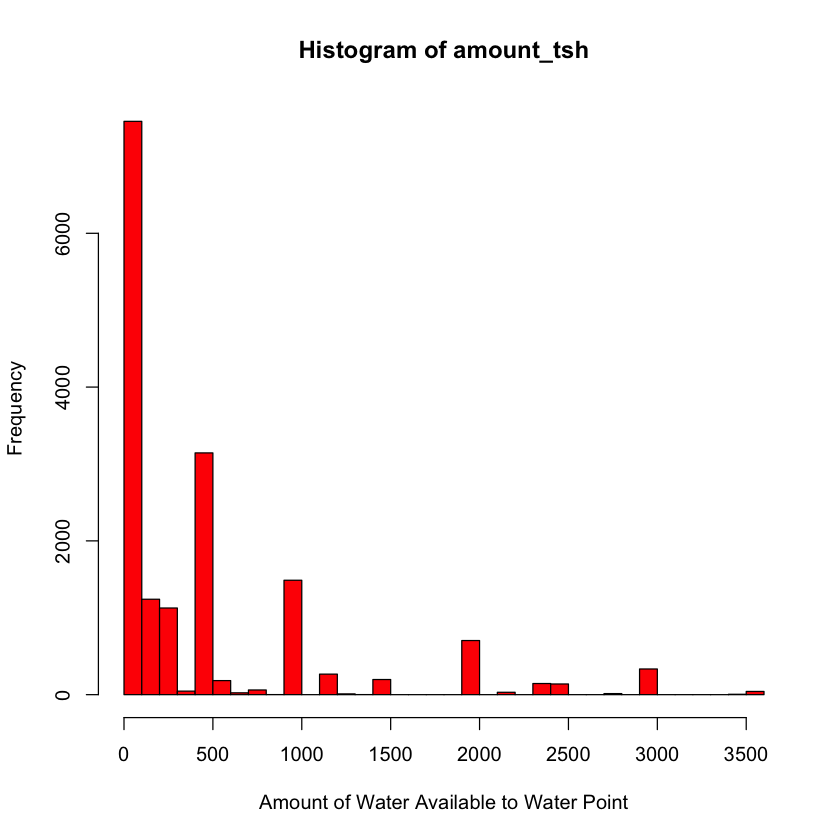

In [9]:
hist(water$amount_tsh[water$amount_tsh<4000], breaks=50, col="red", xlab="Amount of Water Available to Water Point",
    main='Histogram of amount_tsh')


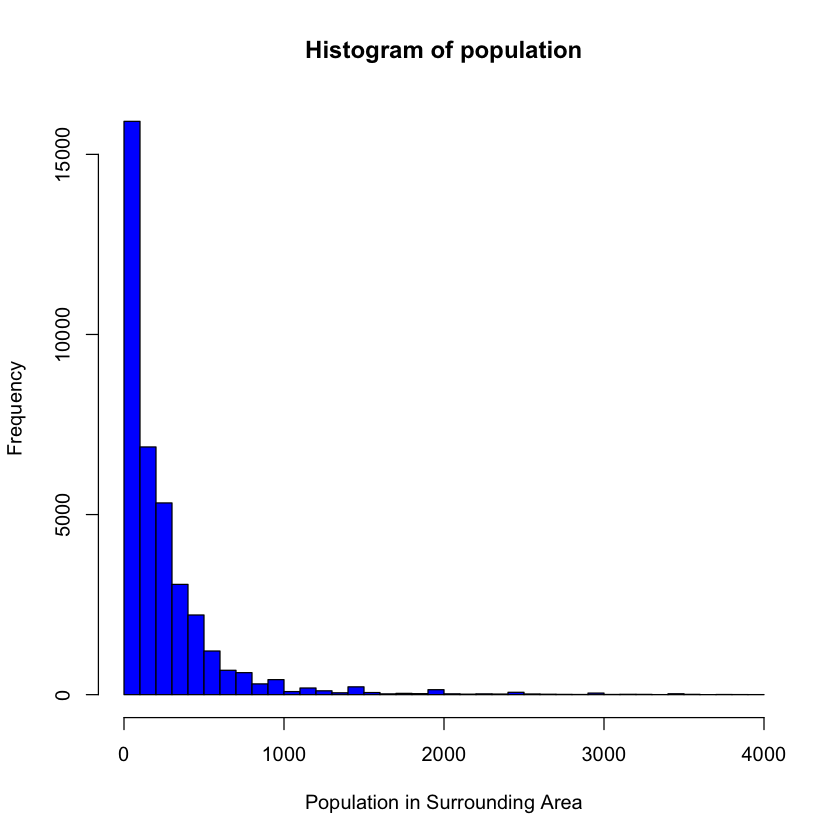

In [10]:
hist(water$population[water$population<4000], breaks=50, col="blue", xlab="Population in Surrounding Area",
    main='Histogram of population')

Both amount_tsh and population appear to be right skewed, and so imputing the missing values with the feature mean value would be unwise. However imputing with the feature median value would allow us to include these records in the analysis without adding inaccurate information that may impact the feature effects on the model. So I will impute missing values for both of these features with the median values.

In [11]:
water$amount_tsh[is.na(water$amount_tsh)]<-median(water$amount_tsh, na.rm = TRUE)
water$population[is.na(water$population)]<-median(water$population, na.rm = TRUE)

Now, extraction_type, extraction_type_group and extraction_type_class seem to impart roughly the same information. That said, extraction_type_class seems to have categories that are better interpretable. So I will eliminate extraction_type and extraction_type_group.

Quantity and quantity_group are identical, so I will eliminate quantity_group.

Water_quality and quality_group are also somewhat redundant, so I will eliminate water_quality.

Source and source_type are roughly the same, so I will eliminate source.

And finally, waterpoint_type and waterpoint_type_group are very similar, so I will eliminate waterpoint_type_group.

In [12]:
water$waterpoint_type_group<- water$extraction_type_group<- water$quantity_group<- 
water$water_quality<- water$extraction_type<- water$source<-NULL

Now the only other data quality issues pertain to scheme_management and permit. They both have a small quantity (~3,000) of missing values (indicated by the blank factor values in the summary listing.) I will ignore that and simply do a complete case analysis when modeling time comes.

In [13]:
summary(water)

       id          amount_tsh         gps_height                 basin      
 Min.   :    0   Min.   :     0.2   Min.   : -90.0   Lake Victoria  :10248  
 1st Qu.:18520   1st Qu.:   250.0   1st Qu.:   0.0   Pangani        : 8940  
 Median :37062   Median :   250.0   Median : 369.0   Rufiji         : 7976  
 Mean   :37115   Mean   :   492.9   Mean   : 668.3   Internal       : 7785  
 3rd Qu.:55656   3rd Qu.:   250.0   3rd Qu.:1319.2   Lake Tanganyika: 6432  
 Max.   :74247   Max.   :350000.0   Max.   :2770.0   Wami / Ruvu    : 5987  
                                                     (Other)        :12032  
   population            scheme_management   permit       extraction_type_class
 Min.   :    1.0   VWC            :36793        : 3056   gravity     :26780    
 1st Qu.:  100.0   WUG            : 5206   False:17492   handpump    :16456    
 Median :  150.0                  : 3877   True :38852   motorpump   : 2987    
 Mean   :  233.9   Water authority: 3153                 other  

### Now I am ready to model

#### First pass:
I will construct a multinomial logistic regression model. The response variable is status_group (recoded below as "response"), and the predictor variables are amount_tsh, gps_height, basin, population, scheme_management, permit, extraction_type_class, quality_group, quantity, source_type, source_class, and waterpoint_type.

In [15]:
library(foreign)
library(nnet)
library(reshape2)

#designate a reference level for our response variable
water$response <- relevel(water$status_group, ref = "functional")

model1<- multinom(response ~ amount_tsh+gps_height+basin+population+
                  scheme_management+permit+extraction_type_class+
                  quality_group+quantity+source_type+
                  waterpoint_type, data = water)
summary(model1)

# weights:  162 (106 variable)
initial  value 65257.569947 
iter  10 value 49745.151006
iter  20 value 46994.368342
iter  30 value 45669.343823
iter  40 value 42886.887257
iter  50 value 42156.941691
iter  60 value 41391.943103
iter  70 value 40899.603112
iter  80 value 40729.437854
iter  90 value 40675.303917
iter 100 value 40639.226809
final  value 40639.226809 
stopped after 100 iterations


Call:
multinom(formula = response ~ amount_tsh + gps_height + basin + 
    population + scheme_management + permit + extraction_type_class + 
    quality_group + quantity + source_type + waterpoint_type, 
    data = water)

Coefficients:
                        (Intercept)    amount_tsh    gps_height basinLake Nyasa
functional needs repair  -0.9728053 -1.440662e-05 -2.701636e-04      -0.9579941
non functional            3.6215804 -1.478460e-04 -7.490359e-05      -0.5107924
                        basinLake Rukwa basinLake Tanganyika basinLake Victoria
functional needs repair       1.1023883            0.6083561          0.5976945
non functional                0.9757073            0.4047491          0.4671834
                        basinPangani basinRufiji basinRuvuma / Southern Coast
functional needs repair   -0.3538420  -0.2646051                    0.6183342
non functional             0.4958058   0.1962345                    0.4476776
                        basinWami / Ruvu    popu

In [16]:
test=read.csv('test_set_features.csv', header=T)
submission=predict(model1, newdata=test)
submission=as.data.frame(submission)
submission=cbind(test[1],submission)
write.csv(submission, file = "submission.csv")

This results in a ~72% accuracy rate. Now I suspect the reason for such a low accuracy rating is the class imbalance for status_group. The "functional needs repair" level has only 4317 examples, as opposed to ~22,000 and ~32,000 for the "non functional" and "functional" levels respectively. So I am going to resample the dataset so that we have equal numbers of each category, and then run the multinomial logistic model again.

In [17]:
nonf=water[water$status_group=='non functional',]
func=water[water$status_group=='functional',]
nonfnr=water[water$status_group=='functional needs repair',]
newnonf=nonf[sample(nrow(nonf),4317),]
newfunc=func[sample(nrow(func),4317),]
newset=rbind(nonfnr,newnonf,newfunc)

In [18]:
newset$response <- relevel(newset$status_group, ref = "functional")

model2<- multinom(response ~ amount_tsh+gps_height+basin+population+
                  scheme_management+permit+extraction_type_class+
                  quality_group+quantity+source_type+
                  waterpoint_type, data = newset)

# weights:  162 (106 variable)
initial  value 14228.127751 
iter  10 value 12787.235775
iter  20 value 11616.503529
iter  30 value 11347.430194
iter  40 value 11218.989218
iter  50 value 11176.164602
iter  60 value 11164.056529
iter  70 value 11153.522535
iter  80 value 11152.066363
iter  90 value 11151.968285
iter 100 value 11151.901150
final  value 11151.901150 
stopped after 100 iterations


In [19]:
test=read.csv('test_set_features.csv', header=T)
submission2=predict(model2, newdata=test)
submission2=as.data.frame(submission2)
submission2=cbind(test[1],submission2)
write.csv(submission2, file = "submission2.csv")

This actually fared far worse than the first Logistic Regression model, with ~60% accuracy rating. This is actually to be expected - after all here we used a subset of less than 15,000 observations, which naturally gives us a lot less information than the nearly 60,000 observation original dataset.

The next thing I'd like to try is the "pmlr" package, which takes the response variable class imbalance into consideration. This function seems to crash my kernel, so I will need to do some further research before proceeding any further with this modeling method (and in fact with this analysis.) The general thought here is that I can theoretically benefit from what is called "Penalized Likelihood" Methods, which perform much better when the response variables in GLMs have values that denote "rare events", and thus cause a class imbalance.

Stay tuned...